In [1]:
gene_familly = "AP2"

In [2]:
# Parameters
gene_familly = "GATA"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA, DNA_MPI
from visualization import VISU, VISUReport
from feature_selection import SelectKFeature

[MacBook-Pro-de-Genereux.local:16457] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/2916548608/sm_segment.MacBook-Pro-de-Genereux.501.add70000.0 could be created.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE
gene_info_path = "../data/gene_info_small.json"
trainset_path  = "../data/mix_data/trainset/"
testset_path   = "../data/mix_data/testset/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

# FOCUS ON GENE FAMALLY
gene_dict = gene_info[gene_familly]
df_path = trainset_path+gene_dict['file_code']+".csv"
ts_path = testset_path+gene_dict['file_code']+".csv"

#LOAD DF
USE_FULL_DF = True
if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
else:
    dataset_ = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)

In [6]:
dataset.head()

,Unnamed: 0,id,sequence,length,class
0,1573,XP_010935873.1,MATAMKKYVDDAMAEPLDVMCGGLFDHIDDLLDFPNDDDVLGMVDP...,383,1
1,8318,Glyma.18G134200.2.p,MTVDEVGSSSQWSKEQDKAFENALAIHPEDASDRWEKIAADVPGKT...,297,0
2,7725,Cotton_A_21713_BGI-A2_v1.0,MSCNGCRILRKGCSENCMLRQSLQCIENPQAQAHATVFVAKFFGRA...,216,0
3,9205,OB01G33230.1,MQAWLVLCLCVVLSATDEFSVILIDFGTVLLLSPFLRLGLLCLVDL...,155,0
4,4080,RrC4986_p1,MEKQQQQPTPELLLVAGNADSFVVDDLLDFSNDNGQPEDVFESLPD...,311,1


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8511 entries, 0 to 8510
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8511 non-null   int64 
 1   id          8511 non-null   object
 2   sequence    8511 non-null   object
 3   length      8511 non-null   int64 
 4   class       8511 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 332.6+ KB


In [8]:
#sns.set(style="whitegrid")
#sns.violinplot(x=dataset.length)
#plt.title("sequence length distribution in test sequences")
#plt.show()

In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model-ft/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
21**2

441

In [12]:
k        = 2
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=200, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [13]:
X_train, y_train, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AC,AE,AH,AI,AR,AT,AX,AY,CA,CG,...,YE,YF,YI,YL,YM,YP,YQ,YR,YW,YY
0,0.000000,0.011561,0.000000,0.000000,0.002890,0.002890,0.0,0.002890,0.00000,0.002890,...,0.000000,0.000000,0.000000,0.000000,0.0,0.008671,0.005780,0.000000,0.0,0.002890
1,0.002410,0.001205,0.001205,0.004819,0.001205,0.002410,0.0,0.000000,0.00241,0.002410,...,0.006024,0.001205,0.002410,0.001205,0.0,0.002410,0.001205,0.003614,0.0,0.001205
2,0.000000,0.002421,0.000000,0.000000,0.002421,0.007264,0.0,0.000000,0.00000,0.002421,...,0.000000,0.000000,0.002421,0.000000,0.0,0.002421,0.002421,0.000000,0.0,0.000000
3,0.002611,0.002611,0.000000,0.000000,0.005222,0.002611,0.0,0.005222,0.00000,0.002611,...,0.000000,0.000000,0.000000,0.002611,0.0,0.002611,0.002611,0.000000,0.0,0.000000
4,0.003690,0.000000,0.000000,0.000000,0.003690,0.011070,0.0,0.000000,0.00000,0.011070,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.007380,0.0,0.000000


In [14]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (8511, 200)
X_test: (2128, 200)
y_train: (8511,)
y_test: (2128,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [15]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,721 (370.00 KB)

 Trainable params: 94,721 (370.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1:26 818ms/step - accuracy: 0.2656 - loss: 0.6935

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6531 - loss: 0.6850    

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7363 - loss: 0.6407

 91/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7791 - loss: 0.5761

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7959 - loss: 0.5435 - val_accuracy: 0.9724 - val_loss: 0.0881


Epoch 2/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9531 - loss: 0.1194

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9649 - loss: 0.0884 

 58/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9672 - loss: 0.0854

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9683 - loss: 0.0838

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9691 - loss: 0.0830 - val_accuracy: 0.9624 - val_loss: 0.0991


Epoch 3/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0589

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9789 - loss: 0.0667 

 59/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.0678

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0689

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9771 - loss: 0.0692 - val_accuracy: 0.9724 - val_loss: 0.0804


Epoch 4/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9531 - loss: 0.1152

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9778 - loss: 0.0715 

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9794 - loss: 0.0666

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9796 - loss: 0.0652

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9795 - loss: 0.0647 - val_accuracy: 0.9812 - val_loss: 0.0594


Epoch 5/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0456

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0648 

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0613

 80/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0609

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0607

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0607 - val_accuracy: 0.9836 - val_loss: 0.0552


Epoch 6/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0507

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0430 

 57/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9860 - loss: 0.0515

 85/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9833 - loss: 0.0571

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9825 - loss: 0.0585 - val_accuracy: 0.9853 - val_loss: 0.0526


Epoch 7/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0075

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0319 

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0354

 90/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0379

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0394 - val_accuracy: 0.9806 - val_loss: 0.0570


Epoch 8/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0617

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0429 

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0460

 90/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0474

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0473 - val_accuracy: 0.9830 - val_loss: 0.0521


Epoch 9/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0192

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0476 

 58/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9838 - loss: 0.0450

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9836 - loss: 0.0465

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.0472 - val_accuracy: 0.9794 - val_loss: 0.0530


Epoch 10/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9688 - loss: 0.0598

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.0396 

 58/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9865 - loss: 0.0414

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9857 - loss: 0.0434

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0444 - val_accuracy: 0.9800 - val_loss: 0.0526


Epoch 11/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0261

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0361 

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0403

 92/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0421

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0424 - val_accuracy: 0.9841 - val_loss: 0.0497


Epoch 12/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0199

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0386 

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0405

 80/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0407

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0399

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0399 - val_accuracy: 0.9777 - val_loss: 0.0664


Epoch 13/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9844 - loss: 0.0457

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.0517 

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0456

 80/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0432

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.0414

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0412 - val_accuracy: 0.9806 - val_loss: 0.0513


Epoch 14/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0029

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0208 

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0269

 80/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0322

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0351

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0352 - val_accuracy: 0.9800 - val_loss: 0.0515


Epoch 15/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0104

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0288 

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0273

 80/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0268

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0272

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0272 - val_accuracy: 0.9865 - val_loss: 0.0424


Epoch 16/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0045

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0324 

 55/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0267

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0248

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0243 - val_accuracy: 0.9765 - val_loss: 0.0645


Epoch 17/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0045

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0193 

 52/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0209

 79/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0214

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0218

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0218 - val_accuracy: 0.9865 - val_loss: 0.0394


Epoch 18/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0166

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0309 

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0313

 83/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0314

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0312 - val_accuracy: 0.9783 - val_loss: 0.0548


Epoch 19/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0089

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0113 

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0155

 84/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0172

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0185 - val_accuracy: 0.9589 - val_loss: 0.1165


Epoch 20/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0183

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9839 - loss: 0.0432 

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0363

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0330

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0309 - val_accuracy: 0.9859 - val_loss: 0.0396


Epoch 21/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0050

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0100 

 57/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0127

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0139

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0147 - val_accuracy: 0.9841 - val_loss: 0.0446


Epoch 22/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0049

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0135 

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0126

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0125

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0131

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0136 - val_accuracy: 0.9894 - val_loss: 0.0339


Epoch 23/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0032

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0193 

 59/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0200

 84/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0193

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0185 - val_accuracy: 0.9894 - val_loss: 0.0384


Epoch 24/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 5.2280e-04

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0088     

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0085

 83/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0090

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0102 - val_accuracy: 0.9871 - val_loss: 0.0381


Epoch 25/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0079

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0306 

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0288

 79/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0262

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0244

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0243 - val_accuracy: 0.9783 - val_loss: 0.0625


Epoch 26/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0025

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0130 

 58/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0139

 85/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0148

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0154 - val_accuracy: 0.9877 - val_loss: 0.0371


Epoch 27/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0025

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0080 

 58/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0088

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0091

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0095 - val_accuracy: 0.9853 - val_loss: 0.0406


Epoch 28/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0010

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0084 

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0121

 84/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0130

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0130 - val_accuracy: 0.9871 - val_loss: 0.0411


Epoch 29/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 4.2385e-04

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0115     

 52/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0152

 78/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0167

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0167

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0167 - val_accuracy: 0.9841 - val_loss: 0.0443


Epoch 30/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0023

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0158 

 57/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0120

 85/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0105

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0099 - val_accuracy: 0.9871 - val_loss: 0.0439


Epoch 31/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 3.6131e-04

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0023     

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0044

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0057

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0066 - val_accuracy: 0.9912 - val_loss: 0.0342


Epoch 32/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0043

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0054 

 55/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0051

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0053

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0068 - val_accuracy: 0.9853 - val_loss: 0.0404


Epoch 33/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 5.6313e-04

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0062     

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0077

 80/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0077

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0079

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0079 - val_accuracy: 0.9883 - val_loss: 0.0385


Epoch 34/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0019

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0070 

 55/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0074

 83/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0087

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0094 - val_accuracy: 0.9859 - val_loss: 0.0433


Epoch 35/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0021

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0077 

 59/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0101

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0129

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0138 - val_accuracy: 0.9830 - val_loss: 0.0511


Epoch 36/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0150

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0064 

 55/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0063

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0064

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0067 - val_accuracy: 0.9736 - val_loss: 0.0854


Epoch 37/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0064

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0077 

 58/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0064

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0063

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0062 - val_accuracy: 0.9789 - val_loss: 0.0923


Epoch 38/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0035

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0050 

 58/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0091

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0104

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0107 - val_accuracy: 0.9894 - val_loss: 0.0328


Epoch 39/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0102

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0085 

 58/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0102

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0104

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0104 - val_accuracy: 0.9888 - val_loss: 0.0379


Epoch 40/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0052

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0058 

 58/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0070

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0100

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0109 - val_accuracy: 0.9853 - val_loss: 0.0495


Epoch 41/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0017

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0044 

 57/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0047

 84/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0047

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0052 - val_accuracy: 0.9771 - val_loss: 0.0825



[Train Accuracy: 99.74% - Test Accuracy: 97.93%]


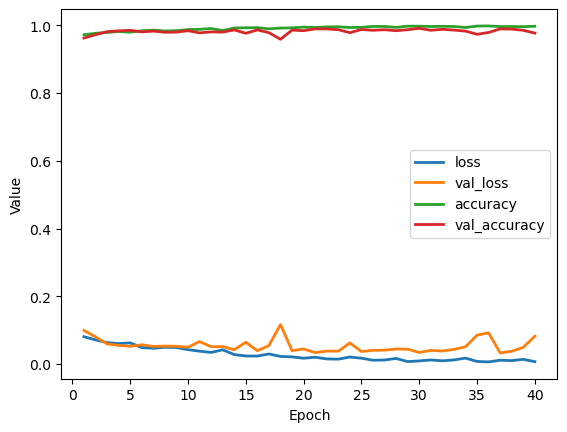

In [16]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [17]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/67 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


 1/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [18]:
21**3

9261

In [19]:
k        = 3
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['rf', 0.1])

In [20]:
X_train, y_train, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,LCN,ACG,CNA,NAC,PEY,SLC,PQW,GPK,PLW,TPL,...,GKL,RAT,LPQ,PKK,KIQ,VTT,KIV,ASQ,VGF,EFS
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,0.001206,0.001206,0.001206,0.001206,0.001206,0.000000,0.001206,0.001206,0.000000,0.001206,...,0.0,0.0,0.0,0.000000,0.001206,0.001206,0.0,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.002427,0.000000,0.0,0.0,0.002427,0.0
3,0.002618,0.002618,0.002618,0.002618,0.000000,0.002618,0.000000,0.002618,0.002618,0.002618,...,0.0,0.0,0.0,0.002618,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,0.003704,0.003704,0.003704,0.003704,0.003704,0.000000,0.003704,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [21]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (8511, 1000)
X_test: (2128, 1000)
y_train: (8511,)
y_test: (2128,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,521 (1.14 MB)

 Trainable params: 299,521 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1:19 749ms/step - accuracy: 0.5938 - loss: 0.6928

 16/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5021 - loss: 0.6915    

 33/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5146 - loss: 0.6828

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5509 - loss: 0.6620

 67/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5928 - loss: 0.6333

 85/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6320 - loss: 0.6003

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6629 - loss: 0.5681

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6724 - loss: 0.5571 - val_accuracy: 0.9900 - val_loss: 0.0452


Epoch 2/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9844 - loss: 0.0598

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9872 - loss: 0.0495 

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9887 - loss: 0.0437

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9889 - loss: 0.0421

 70/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9887 - loss: 0.0416

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9887 - loss: 0.0410

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9887 - loss: 0.0404

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9887 - loss: 0.0404 - val_accuracy: 0.9918 - val_loss: 0.0331


Epoch 3/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0126

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9947 - loss: 0.0176 

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9948 - loss: 0.0174

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9950 - loss: 0.0170

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.0175

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9947 - loss: 0.0179

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.0185

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.0186 - val_accuracy: 0.9871 - val_loss: 0.0513


Epoch 4/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0051

 20/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9922 - loss: 0.0148 

 38/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9924 - loss: 0.0161

 57/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9929 - loss: 0.0166

 74/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9932 - loss: 0.0169

 92/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0171

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0172 - val_accuracy: 0.9930 - val_loss: 0.0407


Epoch 5/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0144

 19/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0072 

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0068

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0071

 70/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0073

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0080

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0086

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0087 - val_accuracy: 0.9941 - val_loss: 0.0375


Epoch 6/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0025

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0037 

 32/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0040

 48/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0040

 64/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0042

 80/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0043

 95/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0048

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9985 - loss: 0.0051 - val_accuracy: 0.9883 - val_loss: 0.0588


Epoch 7/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.1020

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - loss: 0.0405 

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9905 - loss: 0.0299

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9919 - loss: 0.0252

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.0223

 83/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9932 - loss: 0.0208

 99/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0194

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9939 - loss: 0.0188 - val_accuracy: 0.9930 - val_loss: 0.0417


Epoch 8/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 3.2007e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0057     

 32/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0053

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0052

 66/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0049

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0047

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0046

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9930 - val_loss: 0.0470


Epoch 9/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 6.4394e-04

 16/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0066     

 32/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0084

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0080

 68/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0073

 85/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0068

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0064

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0063 - val_accuracy: 0.9906 - val_loss: 0.0538


Epoch 10/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0012

 16/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0050 

 33/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0041

 48/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0035

 65/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0031

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0031

 97/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0031

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0031 - val_accuracy: 0.9941 - val_loss: 0.0463


Epoch 11/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.1564e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0026     

 33/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0046

 48/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0051

 63/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0051

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0050

 96/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0048

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0047 - val_accuracy: 0.9941 - val_loss: 0.0436


Epoch 12/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0011

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.3514e-04

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.3167e-04

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0014    

 64/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0018

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0019

 98/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0020

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 0.9924 - val_loss: 0.0442


Epoch 13/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 4.9636e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.0160e-04 

 33/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.3568e-04

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.8136e-04

 67/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.5008e-04

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.3503e-04

 99/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.2104e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.1267e-04 - val_accuracy: 0.9947 - val_loss: 0.0452


Epoch 14/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.8587e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6476e-04 

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6629e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.4235e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6961e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.8094e-04

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9958e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.0220e-04 - val_accuracy: 0.9947 - val_loss: 0.0475


Epoch 15/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 5.8926e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3290e-04 

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.8148e-04

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.8635e-04

 71/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.8369e-04

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.8369e-04

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2286e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.4277e-04 - val_accuracy: 0.9935 - val_loss: 0.0533


Epoch 16/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0037

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011 

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.3249e-04

 52/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.9289e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.2614e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 6.7396e-04

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 9.3690e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9930 - val_loss: 0.0547


Epoch 17/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0856

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0182 

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9969 - loss: 0.0139

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0115

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9974 - loss: 0.0103

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0093

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0087

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0085 - val_accuracy: 0.9941 - val_loss: 0.0418


Epoch 18/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.0968e-04

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017     

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0036

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0039

 70/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0038

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0036

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0034

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9883 - val_loss: 0.0626


Epoch 19/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 5.8307e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6762e-04 

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0895e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.8715e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9567e-04

 85/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9604e-04

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9151e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.8894e-04 - val_accuracy: 0.9941 - val_loss: 0.0480


Epoch 20/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.5878e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.3053e-05 

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.5488e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2799e-04

 67/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3927e-04

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4229e-04

 99/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4288e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.4281e-04 - val_accuracy: 0.9941 - val_loss: 0.0495


Epoch 21/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.0764e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5766e-04 

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 6.1638e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0013    

 68/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0027

 84/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0036

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0042

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0043 - val_accuracy: 0.9930 - val_loss: 0.0416


Epoch 22/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.3538e-04

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.1229e-04 

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.2472e-04

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 6.2923e-04

 70/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 9.1575e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0011    

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0012

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0012 - val_accuracy: 0.9918 - val_loss: 0.0464


Epoch 23/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.1516e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4560e-04 

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4273e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6797e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 2.5414e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 3.4928e-04

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 7.5899e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 9.0192e-04 - val_accuracy: 0.9930 - val_loss: 0.0459



[Train Accuracy: 99.91% - Test Accuracy: 99.53%]


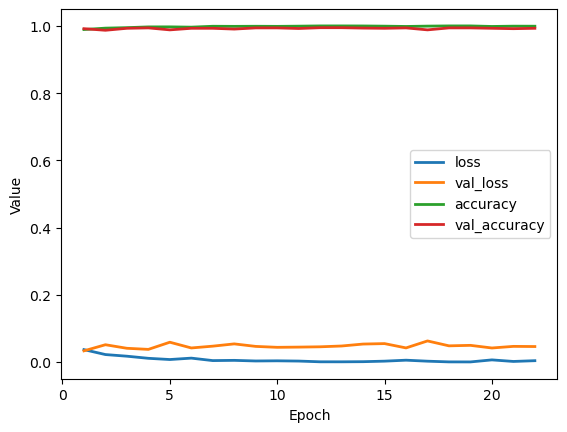

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step


 1/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [25]:
21**4

194481

In [26]:
k        = 4
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [ ]:
X_train, y_train, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

In [ ]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [ ]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

In [ ]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [ ]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

In [ ]:
#report.save()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [ ]:
21**5

In [ ]:
k        = 5
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=min(1300/len(dataset), 1), discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.00001]);

In [ ]:
k = 5
X_train, y_train, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

In [ ]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [ ]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

In [ ]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [ ]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('-ft')

In [ ]:
# END

In [ ]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################